In [7]:
import numpy as np
import argparse
import time
import os
import sys
import pickle
from itertools import chain
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib import cm

root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter

from datasets import inputs, sf_inputs_discrete
from sr_model.models.models import AnalyticSR, STDP_SR, OjaRNN, Linear
import configs
from eval import eval

device = 'cpu'

In [29]:
exp_dir = '../trained_models/05_oja_sf_loss/'

In [57]:
steps = []
losses = []
models = []

for model in os.listdir(exp_dir):
    model_dir = f'{exp_dir}{model}/'
    if not os.path.isdir(model_dir): continue
    if model == 'sr': continue
    for _iter in os.listdir(model_dir):
        iter_dir = f'{model_dir}{_iter}/'
        if not os.path.isdir(iter_dir): continue
        for file in os.listdir(iter_dir):
            if 'tfevents' not in file: continue
            tfevents_file = f'{iter_dir}{file}'
            event_acc = EventAccumulator(tfevents_file)
            event_acc.Reload()
            scalar_events = event_acc.Scalars('loss_train')
            for i in range(len(scalar_events)):
                steps.append(scalar_events[i].step)
                losses.append(scalar_events[i].value)
                models.append(model)
            break

In [58]:
df = pd.DataFrame({
    'Steps': steps, 'Losses': losses,
    'Models': models,
    'Time': np.array(steps)/configs.dt_to_sec/60.
    })

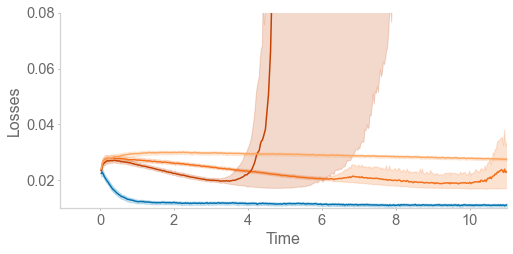

In [105]:
plt.figure(figsize=(6.4*1.25, 4.8*0.75))
cmap = cm.get_cmap('Oranges', 6)
start_cm_idx = 2
palette = [
    cmap(start_cm_idx+1),
    cmap(start_cm_idx+2),
    cmap(start_cm_idx),
    'C0'
    ]
sns.lineplot(
    x='Time', y='Losses', hue='Models', data=df,
    legend=None,
    palette=palette
    )
plt.ylim(0.01, 0.08)
plt.xlim(right=11)
plt.savefig('oja_rnn_loss.png', dpi=300)
plt.show()

oja_0.0005


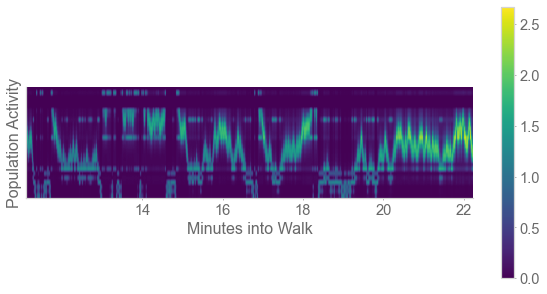

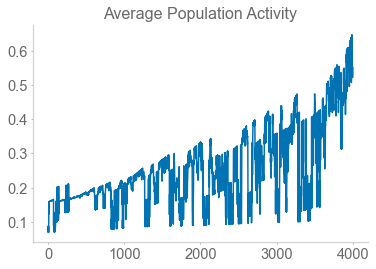

oja_0.001


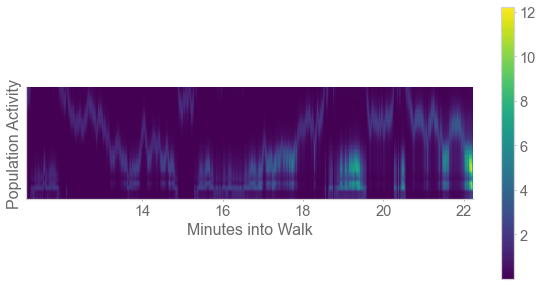

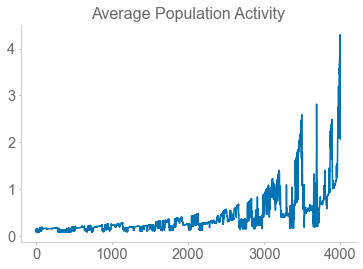

oja_0.0001


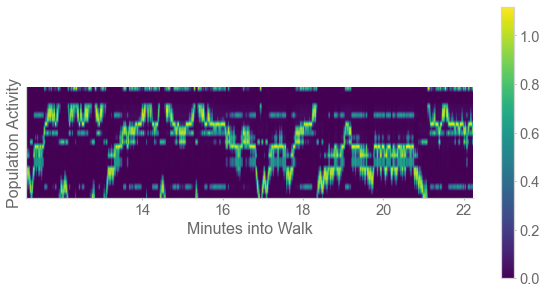

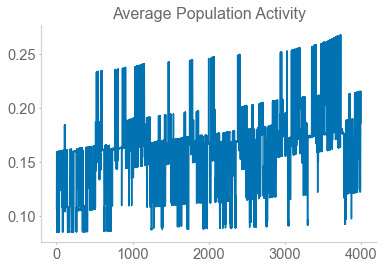

rnn


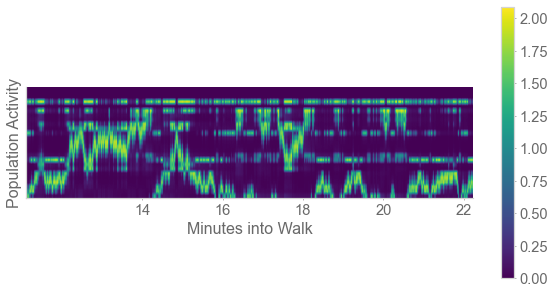

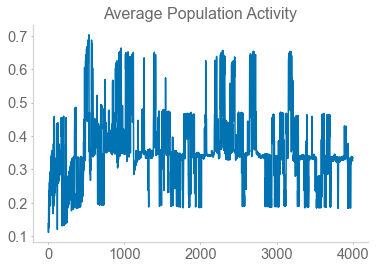

In [102]:
# Plot params
tick_mins = np.array([14, 16, 18, 20, 22])
start_step = 2000
end_step = 4000

for model in os.listdir(exp_dir):
    model_dir = f'{exp_dir}{model}/'
    if not os.path.isdir(model_dir): continue
    if model == 'sr': continue
    print(model)
    results_p = f'{model_dir}output_example.p'
    with open(results_p, 'rb') as f:
        results = pickle.load(f)
    dset = results['dset']
    feature_map = dset.feature_maker.feature_map
    argsort = np.argsort(np.argmax(feature_map, axis=1))
    outputs = results['outputs'][:,argsort]
    
    plt.figure(figsize=(10,5))
    plt.imshow(outputs[start_step:end_step].T, aspect=20, cmap='viridis')
    plt.yticks([])
    plt.ylabel('Population Activity')
    plt.xticks((tick_mins*configs.dt_to_sec*60.)-start_step, tick_mins)
    plt.xlabel('Minutes into Walk')
    plt.colorbar()
    plt.show()
    
    plt.figure()
    plt.plot(np.mean(outputs, axis=1))
    plt.title('Average Population Activity')
    plt.show()